In [5]:
from networkx import add_path
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os


#ward_path = "../data/boundaries/ward boundaries 2018/London_Ward_CityMerged.shp" # Now this does not work 
#wards = gpd.read_file(ward_path).to_crs("EPSG:4326")

# 2024 ward boundaries
ward_path = "../data/raw/Wards_December_2024_Boundaries_UK_BGC/WD_DEC_24_UK_BGC.shp"
wards = gpd.read_file(ward_path).to_crs("EPSG:4326")

base_dir = "../data/crime 2022-2025"

# Monthly burglary counts by ward
monthly_ward_counts = []

# Get all folder names
folders = sorted([f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))])

for folder in folders:
    for file in [f"{folder}-city-of-london-street.csv", f"{folder}-metropolitan-street.csv"]:
        path = os.path.join(base_dir, folder, file)
        if os.path.exists(path):
            print(f"Processing {path}")
            df = pd.read_csv(path, parse_dates=["Month"])
            
            # Filter for burglary crimes
            df = df[df["Crime type"].str.lower() == "burglary"]
            df = df.dropna(subset=["Latitude", "Longitude"])
            df["Month"] = pd.to_datetime(df["Month"]).dt.to_period("M").dt.to_timestamp()

            geometry = [Point(xy) for xy in zip(df["Longitude"], df["Latitude"])]
            gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

            # Spatial join to match burglary points to ward polygons
            gdf = gpd.sjoin(gdf, wards, how="inner", predicate="intersects")

            # Group by month, ward name, and ward code
            counts = gdf.groupby(["Month", "WD24NM", "WD24CD"]).size().reset_index(name="burglary_count")

            # Rename for clarity
            counts.rename(columns={"WD24NM": "Ward name", "WD24CD": "Ward code"}, inplace=True)
            monthly_ward_counts.append(counts)


# Combine
df_monthly = pd.concat(monthly_ward_counts, ignore_index=True)
df_monthly.sort_values(by="Month", inplace=True)

# Save result
output_path = "../data/processed/monthly_burglary_per_ward.csv"
df_monthly.to_csv(output_path, index=False)
print(f"\nSaved monthly burglary counts to: {output_path}")

Processing ../data/crime 2022-2025\2022-04\2022-04-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-04\2022-04-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-05\2022-05-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-05\2022-05-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-06\2022-06-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-06\2022-06-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-07\2022-07-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-07\2022-07-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-08\2022-08-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-08\2022-08-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-09\2022-09-city-of-london-street.csv
Processing ../data/crime 2022-2025\2022-09\2022-09-metropolitan-street.csv
Processing ../data/crime 2022-2025\2022-10\2022-10-city-of-london-street.csv
Processing 

C:\Users\20230920\AppData\Local\Temp\ipykernel_21912\1799024538.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_ts = df[df["Ward name"] == WARD_NAME].set_index("Month").resample("M").sum()


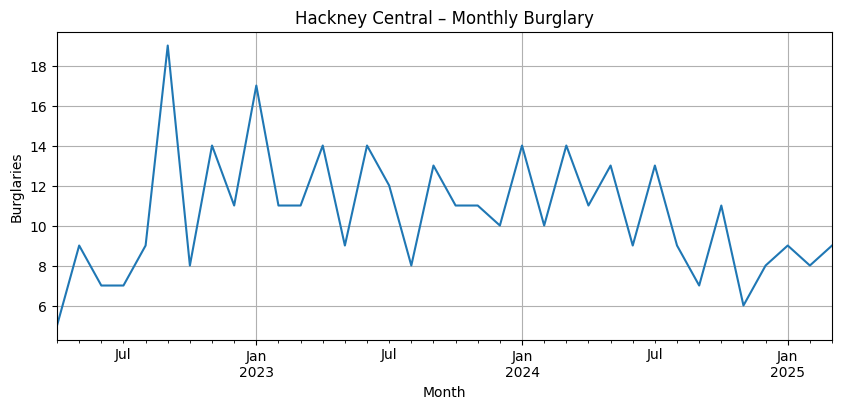

c:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                     burglary_count   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -18.722
Date:                            Tue, 20 May 2025   AIC                             47.444
Time:                                    09:25:44   BIC                             48.430
Sample:                                04-30-2022   HQIC                            45.316
                                     - 03-31-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4491      0.973     -0.462      0.644      -2.356       1.458
ma.L1         -0.6880      1.039   

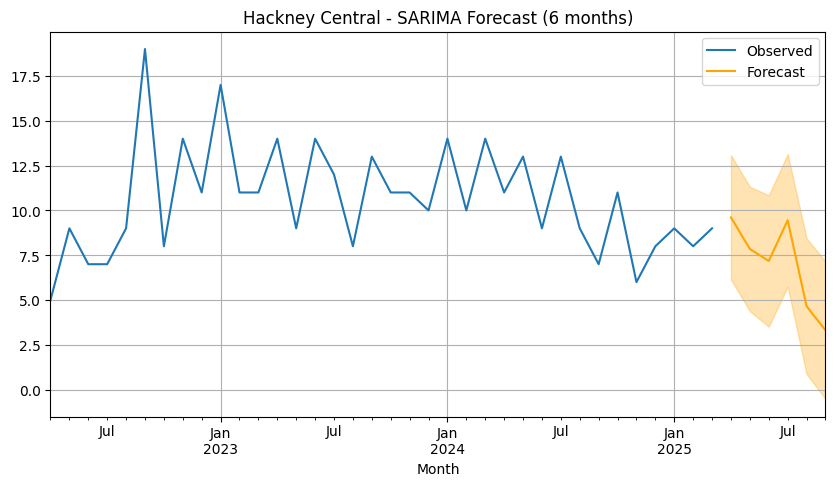

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load burglary data
df = pd.read_csv("../data/processed/monthly_burglary_per_ward.csv", parse_dates=["Month"])

# One random Ward for forecast
WARD_NAME = "Hackney Central"

# Create a time series for that ward 
ward_ts = df[df["Ward name"] == WARD_NAME].set_index("Month").resample("M").sum()

# Plot the original time series
ward_ts["burglary_count"].plot(title=f"{WARD_NAME} – Monthly Burglary", figsize=(10,4))
plt.ylabel("Burglaries")
plt.grid(True)
plt.show()

# Fit SARIMA model (baseline params: (1,1,1)(1,1,1,12))
model = SARIMAX(
    ward_ts["burglary_count"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit(disp=False)
print(results.summary())

#  Forecast next 6 months 
forecast = results.get_forecast(steps=6)
forecast_df = forecast.summary_frame()

# Plot forecast with confidence intervals
plt.figure(figsize=(10, 5))
ward_ts["burglary_count"].plot(label="Observed")
forecast_df["mean"].plot(label="Forecast", color="orange")
plt.fill_between(forecast_df.index, forecast_df["mean_ci_lower"], forecast_df["mean_ci_upper"], color="orange", alpha=0.3)
plt.title(f"{WARD_NAME} - SARIMA Forecast (6 months)")
plt.legend()
plt.grid(True)
plt.show()

# Save forecats
#forecast_df.to_csv(f"../data/processed/forecast_{WARD_NAME.replace(' ', '_')}.csv")
